In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skimage import io, filters
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import cv2
import numpy as np

image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/BUILDING2/tiff/train'
image_files = os.listdir(image_path)
# images_list = sorted(os.listdir(os.path.join(image_path, 'Images')))

mask_path = '/content/drive/MyDrive/Colab Notebooks/dataset/BUILDING2/tiff/train_labels'
mask_files = os.listdir(mask_path)
# masks_list = sorted(os.listdir(os.path.join(mask_path, 'Masks')))

#print (image_files)  #what kinds of rooms are in this dataset

#print("Types of disease found: ", len(image_path))

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        # img = cv2.imread(sorted(os.path.join(folder, filename)))
        if img is not None:
            images.append(img)
    return images
    # Load images and masks
images = load_images_from_folder(image_path)
masks = load_images_from_folder(mask_path)

In [ ]:
def load_and_resize_images_from_folder(folder, target_size=(128,128,)):
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        img = cv2.resize(img, target_size)
        img=img/255.0
        images.append(img)
    return np.array(images)
images = load_and_resize_images_from_folder(image_path)
#masks = load_and_resize_images_from_folder(mask_path)

In [ ]:
from PIL import Image
from tensorflow.keras.utils import to_categorical
num_classes=6
def load_and_resize_images_from_folder(folder, target_size=(128,128,)):
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img=img[:,:,0];
        highest_class = np.max(img)

        # Create binary mask
        binary_mask = np.zeros_like(img)
        binary_mask[img == highest_class] = 1
        img=binary_mask

        # mip_2d = np.max(img, axis=0)

        # # Convert to binary mask
        # img = np.where(mip_2d > 0, 1, 0)


        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        # img = cv2.resize(img.astype(np.uint8), (target_size), interpolation=cv2.INTER_NEAREST)
        img = cv2.resize(img, target_size)
        max_pixel_value = img.max()
        max_pixel_value_float = float(max_pixel_value)
        img=img/max_pixel_value_float
        images.append(img)
    return np.array(images)
#images = load_and_resize_images_from_folder(image_path)
masks = load_and_resize_images_from_folder(mask_path)

In [ ]:
images.shape

(137, 128, 128, 3)

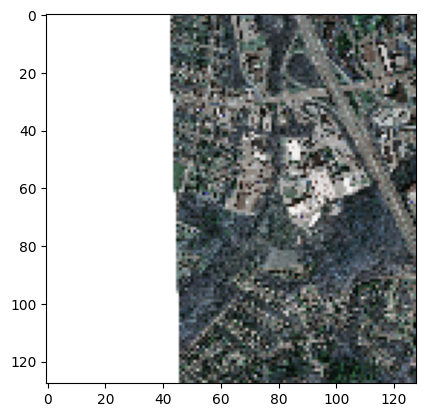

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[45], cmap='gray')

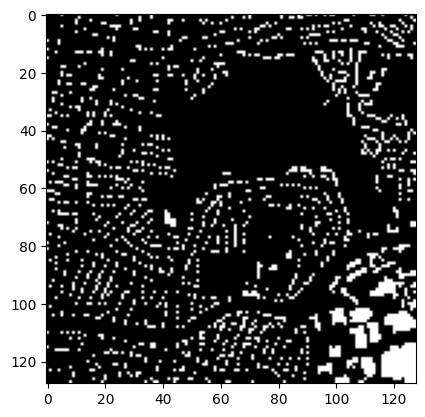

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(masks[5],cmap='gray')

In [ ]:
# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)

In [ ]:
images.shape

(137, 128, 128, 3)

In [ ]:
masks.shape

(137, 128, 128)

In [ ]:
mm=masks[1]
print(np.min(mm))

0.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# print(np.max(masks[100]))

In [ ]:
def augment_image_and_mask(image, mask):
    # List to hold augmented images and masks
    augmented_images = []
    augmented_masks = []

    # Flip horizontally
    img_flip_h = cv2.flip(image, 1)
    mask_flip_h = cv2.flip(mask, 1)
    augmented_images.append(img_flip_h)
    augmented_masks.append(mask_flip_h)

    # Flip vertically
    img_flip_v = cv2.flip(image, 0)
    mask_flip_v = cv2.flip(mask, 0)
    augmented_images.append(img_flip_v)
    augmented_masks.append(mask_flip_v)

    # # Rotate 90 degrees
    # img_rot90 = np.rot90(image)
    # mask_rot90 = np.rot90(mask)
    # augmented_images.append(img_rot90)
    # augmented_masks.append(mask_rot90)

    # Rotate 180 degrees
    img_rot180 = np.rot90(image, 2)
    mask_rot180 = np.rot90(mask, 2)
    augmented_images.append(img_rot180)
    augmented_masks.append(mask_rot180)

    # # Rotate 270 degrees
    # img_rot270 = np.rot90(image, 3)
    # mask_rot270 = np.rot90(mask, 3)
    # augmented_images.append(img_rot270)
    # augmented_masks.append(mask_rot270)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    return augmented_images, augmented_masks

# Apply augmentations and combine with original images and masks
combined_images = []
combined_masks = []

for img, msk in zip(images, masks):
    aug_imgs, aug_msks = augment_image_and_mask(img, msk)

    # Combine original and augmented images
    combined_images.append(img)
    combined_images.extend(aug_imgs)

    # Combine original and augmented masks
    combined_masks.append(msk)
    combined_masks.extend(aug_msks)

# Convert combined lists to numpy arrays
combined_images = np.array(combined_images)
combined_masks = np.array(combined_masks)


In [ ]:
combined_images.shape

(548, 128, 128, 3)

In [ ]:
combined_masks.shape

(548, 128, 128)

In [ ]:
# from tensorflow.keras.layers import Layer
# import tensorflow as tf

# class InvolutionLayer(Layer):
#     def __init__(self, kernel_size=3, stride=1, num_channels=64, **kwargs):
#         super(InvolutionLayer, self).__init__(**kwargs)
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.num_channels = num_channels

#     def build(self, input_shape):
#         self.kernel_map_conv = self.add_weight(
#             shape=(1, 1, input_shape[-1], self.kernel_size * self.kernel_size),
#             initializer='random_normal',
#             trainable=True,
#             name="kernel_map_conv"
#         )

#     def call(self, x):
#         batch_size, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], x.shape[-1]
#         kernel_map = tf.nn.conv2d(x, self.kernel_map_conv, strides=[1, 1, 1, 1], padding='SAME')
#         kernel_map = tf.reshape(kernel_map, [batch_size, height, width, self.kernel_size, self.kernel_size])
#         x_unfolded = tf.image.extract_patches(x, sizes=[1, self.kernel_size, self.kernel_size, 1],
#                                               strides=[1, self.stride, self.stride, 1],
#                                               rates=[1, 1, 1, 1], padding='SAME')
#         x_unfolded = tf.reshape(x_unfolded, [batch_size, height, width, self.kernel_size, self.kernel_size, channels])
#         kernel_map = tf.expand_dims(kernel_map, axis=-1)
#         output = tf.reduce_sum(x_unfolded * kernel_map, axis=[3, 4])
#         return output

#     def compute_output_shape(self, input_shape):
#         return input_shape

#     def get_config(self):
#         config = super(InvolutionLayer, self).get_config()
#         config.update({
#             "kernel_size": self.kernel_size,
#             "stride": self.stride,
#             "num_channels": self.num_channels
#         })
#         return config

# # Register the custom layer when loading or saving the model
# ///////////////////////////////////////
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class InvolutionLayer(Layer):
    def __init__(self, kernel_size=3, stride=1, num_channels=64, **kwargs):
        super(InvolutionLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.stride = stride
        self.num_channels = num_channels

    def build(self, input_shape):
        self.kernel_map_conv = self.add_weight(
            shape=(1, 1, input_shape[-1], self.kernel_size * self.kernel_size),
            initializer='random_normal',
            trainable=True,
            name="kernel_map_conv"
        )

    def call(self, x):
        batch_size, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], x.shape[-1]
        kernel_map = tf.nn.conv2d(x, self.kernel_map_conv, strides=[1, 1, 1, 1], padding='SAME')
        kernel_map = tf.reshape(kernel_map, [batch_size, height, width, self.kernel_size, self.kernel_size])
        x_unfolded = tf.image.extract_patches(x, sizes=[1, self.kernel_size, self.kernel_size, 1],
                                              strides=[1, self.stride, self.stride, 1],
                                              rates=[1, 1, 1, 1], padding='SAME')
        x_unfolded = tf.reshape(x_unfolded, [batch_size, height, width, self.kernel_size, self.kernel_size, channels])
        kernel_map = tf.expand_dims(kernel_map, axis=-1)
        output = tf.reduce_sum(x_unfolded * kernel_map, axis=[3, 4])
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(InvolutionLayer, self).get_config()
        config.update({
            "kernel_size": self.kernel_size,
            "stride": self.stride,
            "num_channels": self.num_channels
        })
        return config


# ///////////////////////////////////////

import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming the InvolutionLayer class is already defined with the get_config method

def conv_block(x, num_filters):
    """A standard convolution block: Conv -> ReLU -> Conv -> ReLU."""
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, num_filters, use_involution=False):
    """Encoder block with optional involution layer."""
    if use_involution:
        # Use involution layer instead of convolution in deeper layers
        x = InvolutionLayer(kernel_size=3, stride=1, num_channels=num_filters)(x)
    else:
        # Use standard convolution block
        x = conv_block(x, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(x, skip, num_filters):
    """Decoder block with skip connections."""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])  # Skip connection
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    """Build U-Net model with a combination of standard convolutions and involution layers."""
    inputs = layers.Input(input_shape)

    # Encoder path (Downsampling)
    s1, p1 = encoder_block(inputs, 64, use_involution=False)  # Standard Conv
    s2, p2 = encoder_block(p1, 128, use_involution=False)     # Standard Conv
    s3, p3 = encoder_block(p2, 256, use_involution=True)      # Involution in deeper layer
    s4, p4 = encoder_block(p3, 512, use_involution=True)      # Involution in deeper layer

    # Bottleneck with involution
    b = InvolutionLayer(kernel_size=3, stride=1, num_channels=1024)(p4)

    # Decoder path (Upsampling)
    d1 = decoder_block(b, s4, 512)  # Decoder block with skip connection
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer (for segmentation, use a single channel with sigmoid for binary segmentation)
    outputs = layers.Conv2D(num_classes, kernel_size=1, activation="sigmoid")(d4)

    # Create model
    model = models.Model(inputs, outputs)
    return model

# Define input shape and number of output classes
input_shape = (128, 128, 3)  # Example for a color image of size 256x256
num_classes = 1  # Example for binary segmentation (1 output channel for mask)

# Build the U-Net model
model = build_unet(input_shape, num_classes)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ involution_layer          │ (None, 32, 32, 128)    │          1,152 │ max_pooling2d_1[0][0]  │
│ (InvolutionLayer)         │                        │                │                        │
├──────────────────────

 Total params: 8,561,985 (32.66 MB)

 Trainable params: 8,557,377 (32.64 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:
# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    alpha=1000
    beta=10
    return beta * bce + alpha * mse

model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_masks, epochs=100, batch_size=20, validation_data=(val_images, val_masks))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7496 - loss: 199.4928 - val_accuracy: 0.1575 - val_loss: 849.9706
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.8609 - loss: 115.2008 - val_accuracy: 0.2071 - val_loss: 897.7788
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8701 - loss: 104.6241 - val_accuracy: 0.6963 - val_loss: 315.0406
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.8726 - loss: 102.0221 - val_accuracy: 0.8853 - val_loss: 105.9089
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8780 - loss: 96.4188 - val_accuracy: 0.8853 - val_loss: 105.6678
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.8788 - loss: 94.9660 - val_accuracy: 0.8853 - val_loss: 107.8513
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.8788 - loss: 94.7397 - val_accuracy: 0.8853 - val_loss: 109.1635
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.88

KeyboardInterrupt: 

In [ ]:
preds = model.predict(val_images)
preds = (preds > 0.5).astype(int)
# preds = np.argmax(preds.squeeze(), axis=-1)
# val_masks1=np.argmax(val_masks.squeeze(), axis=-1)
import matplotlib.pyplot as plt
# Visualizing some predictions
def display_predictions(x, y_true, y_pred):
    plt.figure(figsize=(128, 128))
    for i in range(7):
        plt.subplot(7, 3, i*3+1)
        plt.imshow(x[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(7, 3, i*3+2)
        plt.imshow(y_true[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(7, 3, i*3+3)
        # plt.imshow(y_pred[i], cmap='nipy_spectral')
        # plt.imshow(y_pred[i, 128, 128, 1], cmap='gray')
        plt.imshow(y_pred[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.show()
display_predictions(val_images, val_masks, preds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras.metrics import MeanIoU


preds =model.predict(val_images)

# Squeeze the last dimension of predictions to match the shape of ground truth
pred_binary = np.squeeze(preds)  # Shape becomes (324, 64, 64)

y_pred=pred_binary
y_true=val_masks

# Binarize the predictions using a threshold, e.g., 0.5
threshold = 0.5
y_pred = (y_pred > threshold).astype(int)
y_true = (y_true > threshold).astype(int)



# Flattening arrays if needed
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()


# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice = dice_coefficient(y_true_flat, y_pred_flat)
print(f'Dice Coefficient: {dice:.4f}')

# Intersection over Union (IoU)
def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

iou_score = iou(y_true_flat, y_pred_flat)
print(f'IoU: {iou_score:.4f}')

# Precision
precision = precision_score(y_true_flat, y_pred_flat)
print(f'Precision Score: {precision:.4f}')

# Recall
recall = recall_score(y_true_flat, y_pred_flat)
print(f'Recall: {recall:.4f}')

# Accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f'Accuracy: {accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Dice Coefficient: 0.5277
IoU: 0.3585
Precision Score: 0.6782
Recall: 0.4319
Accuracy: 0.9113


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skimage import io, filters
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import cv2
import numpy as np

image_path = '/content/drive/MyDrive/Colab Notebooks/dataset/BUILDING2/png/test'
image_files = os.listdir(image_path)
# images_list = sorted(os.listdir(os.path.join(image_path, 'Images')))

mask_path = '/content/drive/MyDrive/Colab Notebooks/dataset/BUILDING2/png/test_labels'
mask_files = os.listdir(mask_path)
# masks_list = sorted(os.listdir(os.path.join(mask_path, 'Masks')))

#print (image_files)  #what kinds of rooms are in this dataset

#print("Types of disease found: ", len(image_path))

# ////////////////////////////////////////////

from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        # img = cv2.imread(sorted(os.path.join(folder, filename)))
        if img is not None:
            images.append(img)
    return images
    # Load images and masks
images1 = load_images_from_folder(image_path)
masks1 = load_images_from_folder(mask_path)
# ///////////////////////////////////////////////////////

def load_and_resize_images_from_folder(folder, target_size=(128,128,)):
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        img = cv2.resize(img, target_size)
        img=img/255.0
        images.append(img)
    return np.array(images)
images1 = load_and_resize_images_from_folder(image_path)
#masks = load_and_resize_images_from_folder(mask_path)

# ////////////////////////////////

from PIL import Image
from tensorflow.keras.utils import to_categorical
num_classes=6
def load_and_resize_images_from_folder(folder, target_size=(128,128,)):
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img=img[:,:,0];
        highest_class = np.max(img)

        # Create binary mask
        binary_mask = np.zeros_like(img)
        binary_mask[img == highest_class] = 1
        img=binary_mask

        # mip_2d = np.max(img, axis=0)

        # # Convert to binary mask
        # img = np.where(mip_2d > 0, 1, 0)


        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        # img = cv2.resize(img.astype(np.uint8), (target_size), interpolation=cv2.INTER_NEAREST)
        img = cv2.resize(img, target_size)
        max_pixel_value = img.max()
        max_pixel_value_float = float(max_pixel_value)
        img=img/max_pixel_value_float
        images.append(img)
    return np.array(images)
#images = load_and_resize_images_from_folder(image_path)
masks1 = load_and_resize_images_from_folder(mask_path)

# //////////////////////////////////

# Convert to numpy arrays
images1 = np.array(images1)
masks1 = np.array(masks1)


In [ ]:
preds1 = model.predict(images1)
preds1 = (preds1 > 0.5).astype(int)
# preds = np.argmax(preds.squeeze(), axis=-1)
# val_masks1=np.argmax(val_masks.squeeze(), axis=-1)
import matplotlib.pyplot as plt
# Visualizing some predictions
def display_predictions(x, y_true, y_pred):
    plt.figure(figsize=(128, 128))
    for i in range(7):
        plt.subplot(7, 3, i*3+1)
        plt.imshow(x[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(7, 3, i*3+2)
        plt.imshow(y_true[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(7, 3, i*3+3)
        # plt.imshow(y_pred[i], cmap='nipy_spectral')
        # plt.imshow(y_pred[i, 128, 128, 1], cmap='gray')
        plt.imshow(y_pred[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.show()
display_predictions(images1, masks1, preds1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras.metrics import MeanIoU


preds1 =model.predict(images1)

# Squeeze the last dimension of predictions to match the shape of ground truth
pred_binary1 = np.squeeze(preds1)  # Shape becomes (324, 64, 64)

y_pred=pred_binary1
y_true=masks1

# Binarize the predictions using a threshold, e.g., 0.5
threshold = 0.5
y_pred = (y_pred > threshold).astype(int)
y_true = (y_true > threshold).astype(int)



# Flattening arrays if needed
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()


# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice = dice_coefficient(y_true_flat, y_pred_flat)
print(f'Dice Coefficient: {dice:.4f}')

# Intersection over Union (IoU)
def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

iou_score = iou(y_true_flat, y_pred_flat)
print(f'IoU: {iou_score:.4f}')

# Precision
precision = precision_score(y_true_flat, y_pred_flat)
print(f'Precision Score: {precision:.4f}')

# Recall
recall = recall_score(y_true_flat, y_pred_flat)
print(f'Recall: {recall:.4f}')

# Accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f'Accuracy: {accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Dice Coefficient: 0.5475
IoU: 0.3769
Precision Score: 0.7212
Recall: 0.4413
Accuracy: 0.8669


In [ ]:
# Define the path in Google Drive where you want to save the model
model_path = '/content/drive/MyDrive/Colab Notebooks/invo_Building_model_name_1.keras'

# Save the model
model.save(model_path)

In [ ]:
from tensorflow.keras.models import load_model

# Specify the path where the model is saved
model_path = '/content/drive/MyDrive/Colab Notebooks/invo_Building_model_name.keras'

# Load the model
model = load_model(model_path)

# Verify by checking the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ involution_layer          │ (None, 32, 32, 128)    │          1,152 │ max_pooling2d_1[0][0]  │
│ (InvolutionLayer)         │                        │                │                        │
├──────────────────────

 Total params: 25,676,741 (97.95 MB)

 Trainable params: 8,557,377 (32.64 MB)

 Non-trainable params: 4,608 (18.00 KB)

 Optimizer params: 17,114,756 (65.29 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


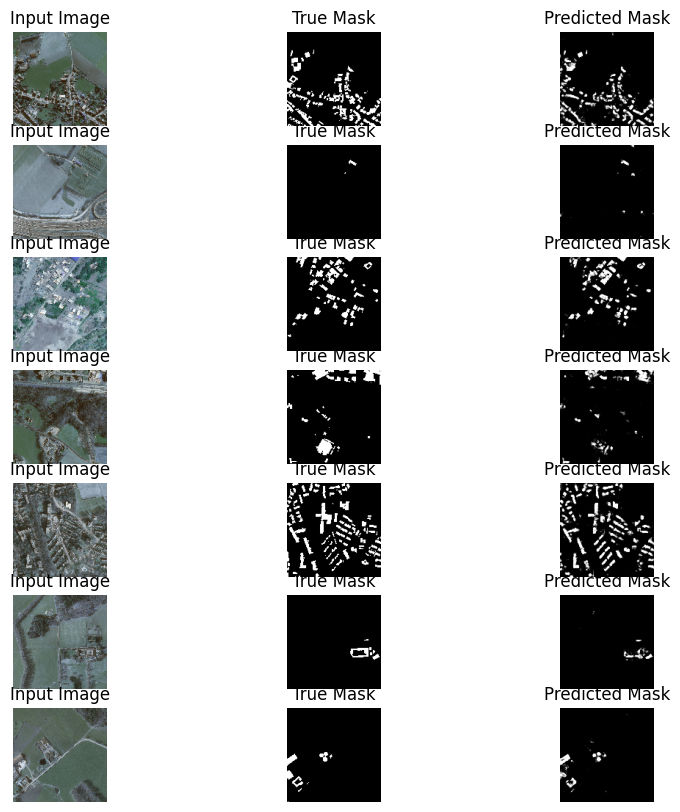

In [ ]:
preds = model.predict(val_images)
# preds = np.argmax(preds.squeeze(), axis=-1)
# val_masks1=np.argmax(val_masks.squeeze(), axis=-1)
import matplotlib.pyplot as plt
# Visualizing some predictions
def display_predictions(x, y_true, y_pred):
    plt.figure(figsize=(10, 10))
    for i in range(7):
        plt.subplot(7, 3, i*3+1)
        plt.imshow(x[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(7, 3, i*3+2)
        plt.imshow(y_true[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(7, 3, i*3+3)
        # plt.imshow(y_pred[i], cmap='nipy_spectral')
        # plt.imshow(y_pred[i, 128, 128, 1], cmap='gray')
        plt.imshow(y_pred[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.show()
display_predictions(val_images, val_masks, preds)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, metrics
import numpy as np
import matplotlib.pyplot as plt

# Define the U-Net model
# def unet_model(input_size=(128, 128, 3)):
#     inputs = layers.Input(input_size)
#     c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
#     c1 = layers.Dropout(0.1)(c1)
#     c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)

#     c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = layers.Dropout(0.1)(c2)
#     c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)

#     c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = layers.Dropout(0.2)(c3)
#     c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#     p3 = layers.MaxPooling2D((2, 2))(c3)

#     c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = layers.Dropout(0.2)(c4)
#     c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#     p4 = layers.MaxPooling2D((2, 2))(c4)

#     c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#     c5 = layers.Dropout(0.3)(c5)
#     c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#     u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#     c6 = layers.Dropout(0.2)(c6)
#     c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

#     u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#     c7 = layers.Dropout(0.2)(c7)
#     c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

#     u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#     c8 = layers.Dropout(0.1)(c8)
#     c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

#     u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = layers.concatenate([u9, c1], axis=3)
#     c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#     c9 = layers.Dropout(0.1)(c9)
#     c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

#     outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

#     model = models.Model(inputs=[inputs], outputs=[outputs])
#     return
from tensorflow.keras import layers, models
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def residual_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    shortcut = layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = residual_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    return x

def build_residual_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = residual_block(p4, 1024)
    # b1 = residual_block(p3, 512)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    outputs = layers.Conv2D(1, (1, 1),activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model



# Define the discriminator model
def discriminator_model(input_size=(128, 128,1 )):
    inputs = layers.Input(input_size)

    d = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
    d = layers.LeakyReLU(alpha=0.0)(d)

    d = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(d)
    d = layers.LeakyReLU(alpha=0.0)(d)

    d = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(d)
    d = layers.LeakyReLU(alpha=0.0)(d)

    d = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(d)
    d = layers.LeakyReLU(alpha=0.0)(d)

    d = layers.Flatten()(d)
    d = layers.Dense(1, activation='sigmoid')(d)

    model = models.Model(inputs=[inputs], outputs=[d])
    return model

# Define the GAN model
def gan_model(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(128, 128, 3))
    gan_output = discriminator(generator(gan_input))
    gan = models.Model(gan_input, gan_output)
    return gan

# Compile the models
input_size = (128, 128, 3)

generator = build_residual_unet(input_size)

input_size = (128, 128, 1)
discriminator = discriminator_model(input_size)
gan = gan_model(generator, discriminator)

generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# generator.summary()
# discriminator.summary()
# gan.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


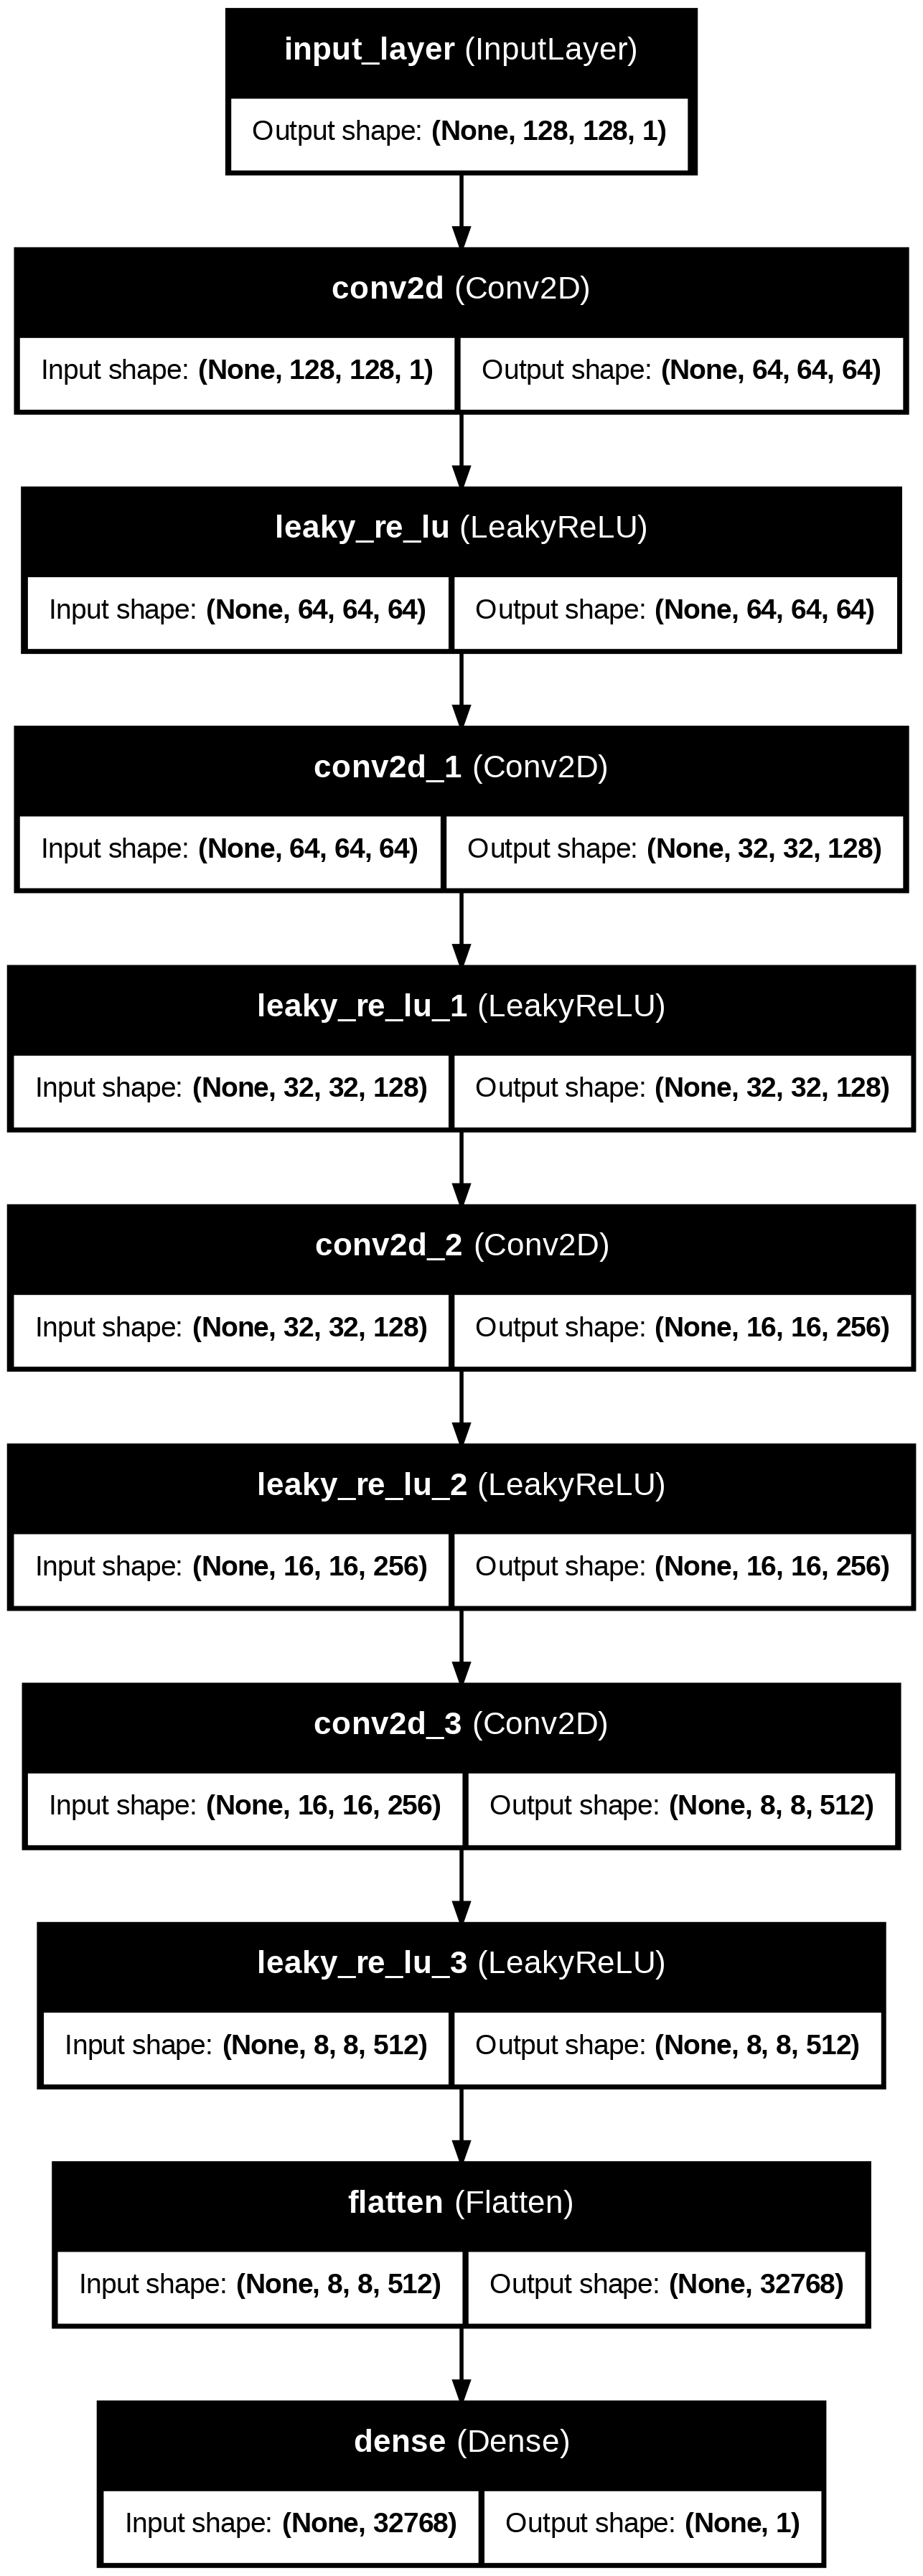

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
import IPython.display as display

# Define the discriminator model
def discriminator_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    d = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(d)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(d)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(d)
    d = layers.LeakyReLU(alpha=0.2)(d)

    d = layers.Flatten()(d)
    d = layers.Dense(1, activation='sigmoid')(d)

    model = models.Model(inputs=[inputs], outputs=[d])
    return model  # Ensure function returns the model

# Create the discriminator model
discriminator = discriminator_model(input_size=(128, 128, 1))  # Call the function

# Generate and save the architecture plot
plot_model(discriminator, to_file='discriminator_model.png', show_shapes=True, show_layer_names=True)

# Display the image in a Jupyter Notebook
display.display(display.Image('discriminator_model.png'))


NameError: name 'model' is not defined

In [ ]:
# # GAN Architecture
# def gan_model(generator):
#     inputs = layers.Input(shape=(128, 128, 3))
#     generated_image = generator(inputs)
#     discriminator = discriminator_model()
#     discriminator.trainable = False
#     validity = discriminator(generated_image)
#     model = keras.Model(inputs, [generated_image, validity])
#     return model


In [ ]:
# Compile and Train the Models
def compile_and_train(generator, gan, discriminator, train_images, train_masks, epochs=100):
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, train_images.shape[0], 32)
        real_images = train_images[idx]
        real_masks = train_masks[idx]
        # noise = np.random.normal(0, 1, (32, 128, 128, 1))
        generated_images = generator.predict(real_images)

        discriminator_loss_real = discriminator.train_on_batch(real_masks, np.ones((32, 1)))
        discriminator_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((32, 1)))
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

        # Train Generator
        # noise = np.random.normal(0, 1, (32, 256, 256, 1))
        noise=real_images
        gan_loss = gan.train_on_batch(noise, [real_masks, np.ones((32, 1))])

        print(f"{epoch}/{epochs} [D loss: {discriminator_loss:.4f} | D accuracy: {100 * discriminator_accuracy:.2f}%] [G loss: {gan_loss:.4f}]")


        # print(f"{epoch}/{epochs} [D loss: {discriminator_loss} | D accuracy: <searchRefSen indexList="1" order="0" >{100 * discriminator_loss</searchRefSen>}] [G loss: {gan_loss}]")


In [ ]:
# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.6, random_state=42, shuffle=True)

In [ ]:
idx = np.random.randint(0, train_images.shape[0], 32)
print(idx)

[128  18  80 108 104 111 102 144  62 144  47  93 100 147 145 129  47 127
 107  58 118 158  20  87 143  67 133  49   9  12   7  92]


In [ ]:
# # Initialize and Compile the Models
# input_shape = (128,128, 3)
# generator = generator(input_shape)
# discriminator = discriminator()
# gan = gan_model(generator)



In [ ]:
# Start Training
compile_and_train(generator, gan, discriminator, train_images,train_masks, epochs=100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(32, 128, 128), output.shape=(32, 1)

In [ ]:
# train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.6, random_state=42, shuffle=True)
# generator.fit(train_images, train_masks, epochs=1000, batch_size=24, validation_data=(val_images, val_masks))

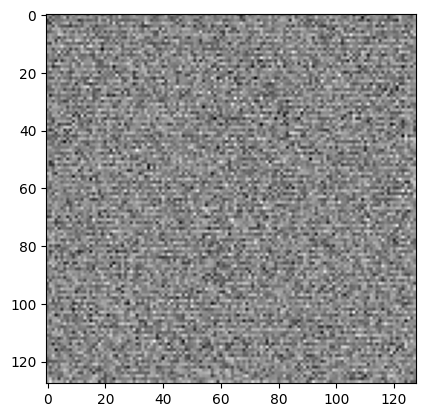

In [ ]:
noise = tf.random.normal([1,128, 128, 3]) #latent space
# noise=val_images[10:11]
generated_image = generator(noise, training=False)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generated_image.shape

TensorShape([1, 128, 128, 1])

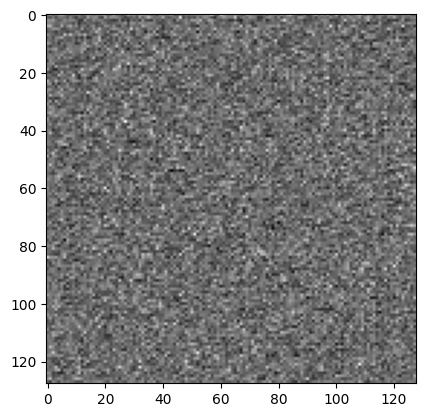

In [ ]:
# sample image generated by the the generator
noise = tf.random.normal([1,128, 128, 3]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50139165]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
####################################################
##  NEW CODE#######################
#####################################################

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset





# Define Loss Functions
def compute_gan_loss(discriminator, generated_output, real_labels):
    discriminator_output = discriminator(generated_output)
    gan_loss = nn.BCELoss()(discriminator_output, real_labels)
    return gan_loss

def compute_segmentation_loss(generator_output, target_segmentation):
    # Example using binary cross-entropy loss
    segmentation_loss = nn.BCEWithLogitsLoss()(generator_output, target_segmentation)
    return segmentation_loss

# Instantiate models
generator = generator()
discriminator = discriminator()

# Define Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in DataLoader:  # Use your DataLoader here
        real_images, target_segmentation = batch
        real_images, target_segmentation = real_images.cuda(), target_segmentation.cuda()

        # Generate images
        optimizer_g.zero_grad()
        generated_images = generator(real_images)

        # Compute GAN loss
        real_labels = torch.ones_like(discriminator(generated_images)).cuda()
        fake_labels = torch.zeros_like(discriminator(generated_images)).cuda()
        gan_loss = compute_gan_loss(discriminator, generated_images, real_labels)

        # Compute Segmentation Loss
        segmentation_loss = compute_segmentation_loss(generated_images, target_segmentation)

        # Total Generator Loss
        generator_loss = gan_loss + segmentation_loss
        generator_loss.backward()
        optimizer_g.step()

        # Update Discriminator
        optimizer_d.zero_grad()
        real_loss = compute_gan_loss(discriminator, target_segmentation, real_labels)
        fake_loss = compute_gan_loss(discriminator, generated_images.detach(), fake_labels)
        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_loss.backward()
        optimizer_d.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Generator Loss: {generator_loss.item()} Discriminator Loss: {discriminator_loss.item()}')


In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.01, random_state=42, shuffle=True)
# generator.fit(train_images, train_masks, epochs=1000, batch_size=24, validation_data=(val_images, val_masks))
# generator.train_on_batch(train_images, train_masks)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(train_images,train_masks,batch_size,discriminator,generator):
    real_images = train_images
    real_masks = train_masks

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(real_images, training=True)

      real_output = discriminator(real_masks, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  # for i in range(predictions.shape[0]):
  for i in range(9):
      plt.subplot(3, 3, i+1)
      # plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
import time
def train(train_images,train_masks, epochs,batch_size):
  for epoch in range(epochs):
    start = time.time()

    for i in range(0, len(train_images), batch_size):
      train_step(train_images[i:i+batch_size],train_masks[i:i+batch_size],batch_size,discriminator,generator)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, train_images)

    # # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, train_images)

In [ ]:
train_images.shape

(67, 128, 128, 3)

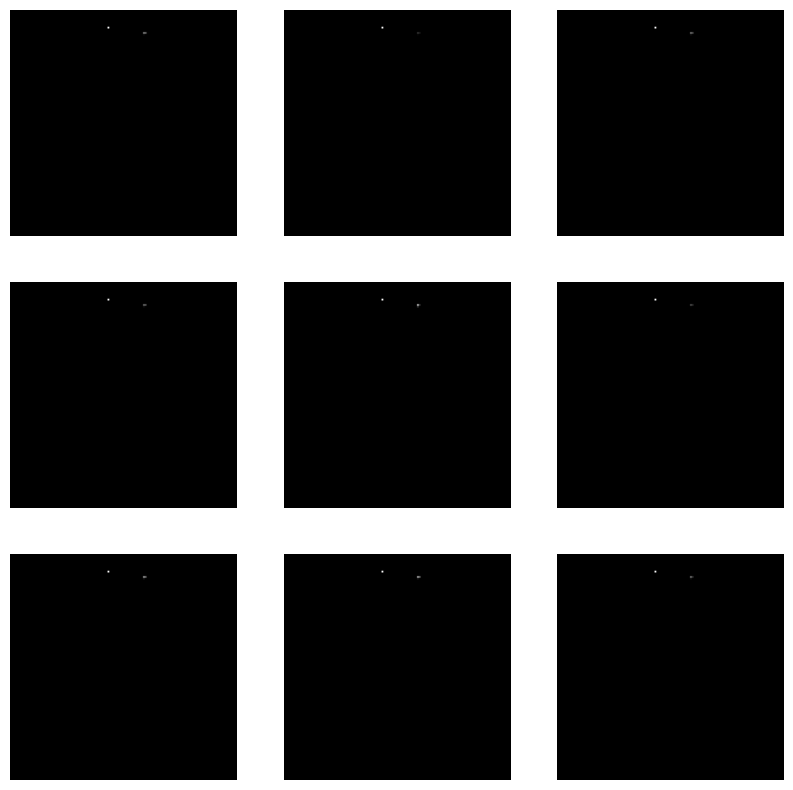

Time for epoch 2 is 3.779672384262085 sec


KeyboardInterrupt: 

In [ ]:
from IPython import display
train_images = train_images[0:60]
train_masks = train_masks[0:60]
epochs=500
batch_size=3
train(train_images,train_masks, epochs,batch_size)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_masks[2],cmap='gray')

NameError: name 'train_masks' is not defined

In [ ]:

noise=val_images[21:22]
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


NameError: name 'val_images' is not defined

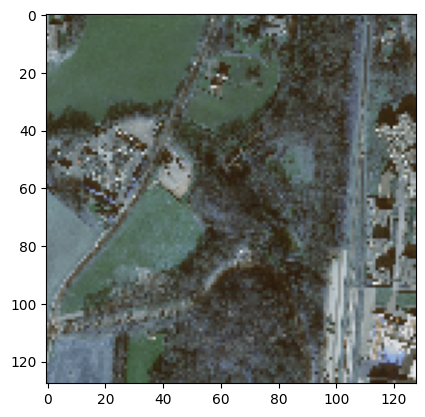

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_images[2],cmap='gray')

In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.1, random_state=42, shuffle=True)
# generator.fit(train_images, train_masks, epochs=1000, batch_size=24, validation_data=(val_images, val_masks))
# generator.train_on_batch(train_images, train_masks)

In [ ]:
train_images.shape

(972, 128, 128, 3)

In [ ]:
# generator.fit(train_images, train_masks, epochs=1000, batch_size=10, validation_data=(val_images, val_masks))

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

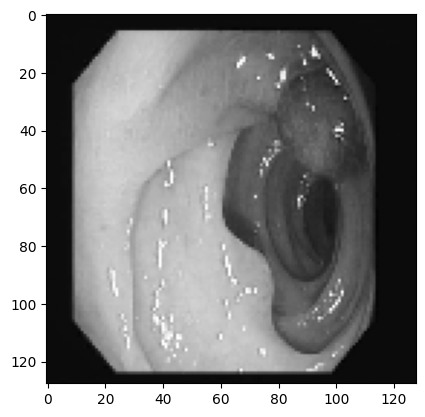

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_images[1],cmap='gray')

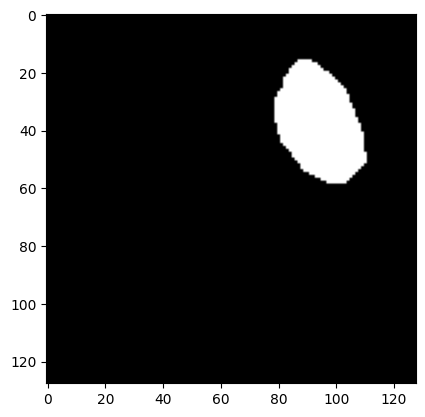

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_masks[1],cmap='gray')

In [ ]:
# train_masks.shape
# bx=ax[0]
# print(bx)
# ms1=np.ones((bx,1))

# cx=val_masks.shape
# dx=cx[0]
# print(dx)
# ms2=np.ones((dx,1))

# # discriminator.fit(train_masks, ms1, epochs=1000, batch_size=24, validation_data=(val_masks, ms2))
# real_masks = train_masks[0:5]
# realms1=ms1[0:5]
# real_masks.shape
# realms1.shape
# discriminator.train_on_batch(real_masks, realms1)
# # discriminator.train_on_batch(train_masks, ms1)

In [ ]:
# # gan.fit(train_images, ms1, epochs=1000, batch_size=24, validation_data=(val_images, ms2))
# gan.train_on_batch(train_images, ms1)

In [ ]:


# Dummy data to initialize metrics
dummy_dataX = np.ones((1,128, 128, 3))
dummy_dataY = np.ones((1,128, 128))
dummy_labelX = np.ones((1, 1))

# dummy_dataX =  train_images[0:1]
# dummy_dataY = train_masks[0:1]
# dummy_labelX = np.ones((1, 1))

# Initialize metrics by running a dummy step
generator.train_on_batch(dummy_dataX, dummy_dataY)
discriminator.train_on_batch(dummy_dataY, dummy_labelX)
gan.train_on_batch(dummy_dataX, dummy_labelX)

[0.7109248638153076, 0.0]

In [ ]:
# # Split the data into training and validation sets
# train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.1, random_state=42, shuffle=True)

# def data_generator(images, masks, batch_size):
#     num_samples = len(images)
#     while True:  # Loop forever so the generator never terminates
#         for offset in range(0, num_samples, batch_size):
#             batch_images = images[offset:offset+batch_size]
#             batch_masks = masks[offset:offset+batch_size]

#             yield batch_images, batch_masks

# batch_size = 10
# train_generator = data_generator(train_images, train_masks, batch_size)
# val_generator = data_generator(val_images, val_masks, batch_size)

In [ ]:
len(train_images)
train_masks[0:0+10].shape

(10, 128, 128)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.1, random_state=42, shuffle=True)

# Example training loop
def train_gan(generator, discriminator, gan, epochs, batch_size, train_images, train_masks):
    for epoch in range(epochs):
        for i in range(0, len(train_images), batch_size):
            real_images = train_images[i:i+batch_size]
            real_masks = train_masks[i:i+batch_size]

            fake_masks = generator.predict(real_images)
            ms1 = np.ones((batch_size, 1))
            ms2 = np.zeros((batch_size, 1))
            # Training the discriminator
            d_loss_real = discriminator.train_on_batch(real_masks, ms1)
            d_loss_fake = discriminator.train_on_batch(fake_masks, ms2)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Training the generator
            ms3 = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(real_images, ms3)

            print(f"Epoch {epoch+1}, Batch {i//batch_size+1}/{len(train_images)//batch_size}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

    return generator

# Assuming you have train_images and train_masks already prepared
# train_images should be (num_samples, 256, 256, 1)
# train_masks should be (num_samples, 256, 256, 1)
# Replace with your actual data loading code
# train_images = images
# train_masks = masks

# train_images1 = np.random.rand(100, 64, 64, 3)
# train_masks1 = np.random.rand(100, 64, 64, 1)

# # Split the data into training and validation sets
# train_images, val_images, train_masks, val_masks = train_test_split(combined_images, combined_masks, test_size=0.1, random_state=42, shuffle=True)

# train_images = np.array(combined_images)
# train_masks = np.array(combined_masks)

# Train the GAN
train_images1 = train_images[0:150]
train_masks1 = train_masks[0:150]
epochs = 500
batch_size=15
steps_per_epoch = len(train_images) // batch_size
trained_generator = train_gan(generator, discriminator, gan, epochs, batch_size, train_images1, train_masks1)

# trained_generator = train_gan(generator, discriminator, gan, epochs, batch_size, train_images, train_masks)

# # Example of generating predictions
# test_image = images[1]
# # Example of generating predictions
# # test_image = np.random.rand(1, 256, 256, 1).astype(np.float32)
# predicted_mask = trained_generator.predict(test_image)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Input Image")
# plt.imshow(test_image[0, :, :, 0], cmap='gray')

# plt.subplot(1, 2, 2)
# plt.title("Predicted Mask")
# plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
# plt.show()

1/1 [==============================] - 6s 6s/step


Epoch 1, Batch 1/10, D Loss: 0.6900367140769958, G Loss: [0.7054758667945862, 0.0]
1/1 [==============================] - 0s 39ms/step
Epoch 1, Batch 2/10, D Loss: 0.6893267929553986, G Loss: [0.6856735348701477, 1.0]
1/1 [==============================] - 0s 23ms/step
Epoch 1, Batch 3/10, D Loss: 0.6887969374656677, G Loss: [0.6711673736572266, 1.0]
1/1 [==============================] - 0s 24ms/step
Epoch 1, Batch 4/10, D Loss: 0.689770519733429, G Loss: [0.6578865051269531, 1.0]
1/1 [==============================] - 0s 22ms/step
Epoch 1, Batch 5/10, D Loss: 0.6889767646789551, G Loss: [0.6441835165023804, 1.0]
1/1 [==============================] - 0s 25ms/step
Epoch 1, Batch 6/10, D Loss: 0.6904875934123993, G Loss: [0.6280481219291687, 1.0]
1/1 [==============================] - 0s 24ms/step
Epoch 1, Batch 7/10, D Loss: 0.6919317841529846, G Loss: [0.6069056391716003, 1.0]
1/1 [==============================] - 0s 29ms/step
Epoch 1, Batch 8/10, D Loss: 0.6916565895080566, G Loss:

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

train_images.shape
plt.imshow(train_images[1])

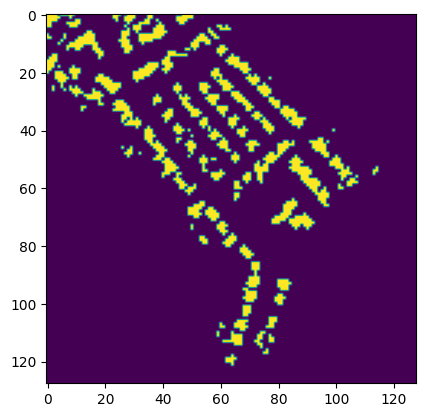

In [ ]:
plt.imshow(train_masks[1])

1/1 [==============================] - 4s 4s/step


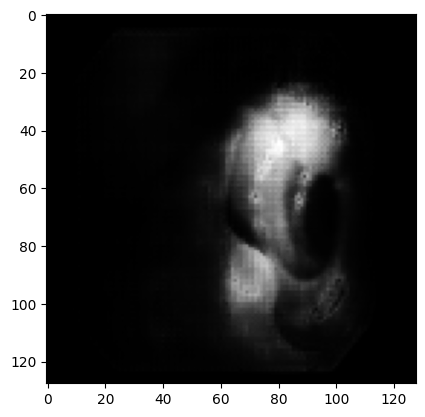

In [ ]:
test_image = train_images[1:2]
# Example of generating predictions
# test_image = np.random.rand(1, 256, 256, 1).astype(np.float32)
predicted_mask = generator.predict(test_image)
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')

In [ ]:
train_masks.shape

(302, 64, 64)